In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Database Reading and Manipulation
import pandas as pd

# Linear Algebra
import numpy as np

# Plotting
import matplotlib.pyplot as plt

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV


# Modeling
from sklearn.tree import DecisionTreeRegressor

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

# Pipeline
from sklearn.pipeline import Pipeline

# Data imputation
from sklearn.impute import SimpleImputer

# Custom modules
## Model selection
from src.cross_validation.blocking_time_series_split import BlockingTimeSeriesSplit

## Function to print scores
from src.utils.print_scores import print_scores

## Function to calculate score regression metrics
from src.utils.score_regression_metrics import score_regression_metrics

## Function to fill the results metric dict
from src.utils.fill_results_dict import fill_results_dict

<IPython.core.display.Javascript object>

# Functions and definitions

In [3]:
index_to_save = 11

<IPython.core.display.Javascript object>

In [4]:
SEED = 47
METRICS = (
    "neg_root_mean_squared_error",
    "neg_mean_absolute_error",
    "neg_mean_absolute_percentage_error",
    "r2",
)
METRICS_DICT = {
    "neg_root_mean_squared_error": "RMSE",
    "neg_mean_absolute_error": "MAE",
    "neg_mean_absolute_percentage_error": "MAPE",
    "r2": "R2",
}

<IPython.core.display.Javascript object>

## Defining a dataframe structure to save the results

In [5]:
results_to_save = []

results_dict = {
    "Category": "Local Model",
    "Company": "partner_i",
    "Features": "Chemical + Mineralogical + Feature Engineering",
    "Data Shape": None,
    "Timesteps": None,
    "Model": "Decision Tree",
    "Model Params": None,
    "Scaler": None,
    "Scaler Params": None,
    "Imputer": None,
    "Imputer Params": None,
    "Cross Validation": None,
    "Cross Validation Params": np.nan,
    "RMSE Train": np.nan,
    "MAE Train": np.nan,
    "MAPE Train": np.nan,
    "R2 Train": np.nan,
    "RMSE Test": np.nan,
    "MAE Test": np.nan,
    "MAPE Test": np.nan,
    "R2 Test": np.nan,
}

<IPython.core.display.Javascript object>

# Reading the dataset

In [6]:
df = pd.read_csv(
    "../../../../../../data/processed/partner_i-Oficial/cement-shipping.csv"
)

<IPython.core.display.Javascript object>

## Defining Features

In this set of experiments we keep only chemical and mineralogical features yielded by the same testing method/procedure

In [7]:
df_copy = df.drop(
    [
        # Properties
        "Blaine",
        "Initial setting time",
        "Final setting time",
        "Density",
        "#200",
        "#325",
        "CS3",
        "CS7",
        
        # Removing One-Hot encoding variables
        "Cement_Type",
        
        
        # Chemical Composition
        # Reason: Loss on Ignition is the only feature
        # that belongs to chemical composition in which was 
        # measured by a different method, namely manual
        
    ],
    axis=1,
).copy()


<IPython.core.display.Javascript object>

## Feature Engineering

In [8]:
# Feature Engineering over Chemical Features
ch_features = ["CaO", "MgO", "Na2O", "Al2O3", "SiO2", "SO3", "K2O", "Fe2O3"]

df_copy["std_ch_feats"] = df_copy[ch_features].std(ddof=0, axis=1)

df_copy["ratio_CaO_to_SiO2"] = df_copy["CaO"] / df_copy["SiO2"]
df_copy["ratio_MgO_to_CaO"] = df_copy["MgO"] / df_copy["CaO"]

# Feature Engineering over Mineralogical Features
mi_features_set1 = [
    "Alpha C2S",
    "Beta C2S",
    "Gamma C2S",
    "C3A",
    "Cubic C3A",
    "Orthorhombic C3A",
]

mi_features_set2 = [
    "Portlandite",
    "Periclase",
    "Arcanite",
    "Aphthitalite",
    "Gypsum",
    "Bassanite",
    "Anhydrite",
    "Calcite",
    "Dolomite",
    "Quartz",
]
df_copy["mean_mi_set1_feats"] = df_copy[mi_features_set1].mean(axis=1)
df_copy["mean_mi_set2_feats"] = df_copy[mi_features_set2].mean(axis=1)

df_copy["ratio_Aluminate_to_Ferrite"] = df_copy["C3A"] / df_copy["C4AF"]

<IPython.core.display.Javascript object>

<h2>1. Dataset: df_copy</h2> <br>In this dataset all features are used.

In [9]:
y = df_copy.pop("CS28").values
x = df_copy.drop(["Date"], axis=1)
dates = df["Date"].copy()

<IPython.core.display.Javascript object>

# 1. Decision Tree Regressor

In [10]:
PARAMS = {
    "criterion": "squared_error",
    "max_depth": 3,
    "random_state": SEED,
    "splitter": "best",
}

<IPython.core.display.Javascript object>

## 1.1 Repeated KFold Cross validation

<b>Dataset shape:</b> (1234, 38)<br>
<b>Repeats:</b>10<br>
<b>Splits:</b>10<br>
    1. 10 folds of 123 samples each
    2. 90% train (1111 samples each fold)
    3. 10% test (123 samples each fold)
<b>Total:</b> 100 models<br>

In [11]:
repeats = 3
n_splits = 5
pipeline = Pipeline(
    [
        ("estimator", DecisionTreeRegressor(**PARAMS)),
    ]
)
cv = RepeatedKFold(n_splits=n_splits, n_repeats=repeats, random_state=SEED)
scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
)
print("Repeated Cross Validation:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Repeated KFold"
results_dict_copy["Cross Validation Params"] = '{"N_Splits": 5, "Repeats": 3}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

Repeated Cross Validation:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -3.365 (0.075)
MAE: -2.330 (0.082)
MAPE: -0.056 (0.002)
R2: 0.555 (0.022)


******
[TEST]
******
RMSE: -3.636 (0.199)
MAE: -2.523 (0.152)
MAPE: -0.060 (0.003)
R2: 0.476 (0.066)




<IPython.core.display.Javascript object>

## 1.2. Blocking Time Series Cross Validation

<b>Dataset shape:</b> (1234, 38)<br>
<b>Splits:</b>5<br>    
    1. 5 folds of 246 samples
    2. 50% train (123 samples each fold)
    3. 50% test (123 samples each fold)
<b>Total:</b> 5 models<br>

In [12]:
n_splits = 5
train_size = 0.8

pipeline = Pipeline(
    [
        ("estimator", DecisionTreeRegressor(**PARAMS)),
    ]
)
cv = BlockingTimeSeriesSplit(n_splits=n_splits, train_size=train_size)
scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
)
print("Blocking Time Series Split:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Blocking Time Series Split"
results_dict_copy[
    "Cross Validation Params"
] = '{"N_Splits": 5, "Repeats": 1, "train_size": 0.8}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

Blocking Time Series Split:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -2.890 (0.272)
MAE: -1.909 (0.270)
MAPE: -0.045 (0.006)
R2: 0.668 (0.070)


******
[TEST]
******
RMSE: -3.847 (0.627)
MAE: -2.537 (0.539)
MAPE: -0.060 (0.012)
R2: 0.373 (0.203)




<IPython.core.display.Javascript object>

## 1.3. Time Series Split Cross Validation

The training set has size i * n_samples // (n_splits + 1) + n_samples % (n_splits + 1) in the i th split, with a test set of size n_samples//(n_splits + 1) by default, where n_samples is the number of samples.


<b>Dataset shape:</b> (1234, 38)<br>
<b>Splits:</b>10<br>    
    1. Train: 10 folds of 114, 226, 338, 450, 562, 675, 787, 899, 1011, 1123 samples each fold
    2. Test: 112 samples each fold
<b>Total:</b> 10 models<br>

In [13]:
n_splits = 5
gap = 0
pipeline = Pipeline(
    [
        ("estimator", DecisionTreeRegressor(**PARAMS)),
    ]
)
cv = TimeSeriesSplit(gap=gap, max_train_size=None, n_splits=n_splits, test_size=None)

scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
)
print("Time Series Split:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Time Series Split"
results_dict_copy["Cross Validation Params"] = '{"N_Splits": 5, "Repeats": 1, "Gap": 0}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

Time Series Split:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -3.073 (0.283)
MAE: -2.094 (0.250)
MAPE: -0.050 (0.006)
R2: 0.612 (0.059)


******
[TEST]
******
RMSE: -3.944 (0.307)
MAE: -2.783 (0.338)
MAPE: -0.066 (0.008)
R2: 0.388 (0.094)




<IPython.core.display.Javascript object>

## 1.4. Out of time Split Cross Validation

<b>Dataset shape:</b> (1234, 38)<br>
<b>Train size: 80%</b><br>
<b>Test  size: 20%</b>


<b>Splits:</b> 2<br>    
    1. Train: 987
    2. Test: 247
<b>Total:</b> 1 model<br>

In [14]:
test_size = 0.2

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=test_size, random_state=SEED, shuffle=False
)
pipeline = Pipeline(
    [
        ("estimator", DecisionTreeRegressor(**PARAMS)),
    ]
)

pipeline.fit(x_train, y_train)

y_train_pred = pipeline.predict(x_train)
y_test_pred = pipeline.predict(x_test)

scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Out of time Split"
results_dict_copy["Cross Validation Params"] = '{"Test Size": 0.2}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(
    results_dict_copy, {key: [value] for key, value in scores.items()}
)
results_to_save.append(df_results)

******
[TRAIN]
******
RMSE: 3.347 (0.000)
MAE: 2.350 (0.000)
MAPE: 0.056 (0.000)
R2: 0.562 (0.000)


******
[TEST]
******
RMSE: 3.368 (0.000)
MAE: 2.320 (0.000)
MAPE: 0.054 (0.000)
R2: 0.542 (0.000)




<IPython.core.display.Javascript object>

In [15]:
pd.concat(results_to_save).groupby(["Features", "Model", "Cross Validation"])[
    ["RMSE Test", "MAE Test", "MAPE Test", "R2 Test"]
].agg(
    ["mean", lambda series: pd.Series(series.std(ddof=0), name="std")]
).reset_index().rename(
    columns={"<lambda_0>": "std"}
)

Features          Model  \
                                                                   
0  Chemical + Mineralogical + Feature Engineering  Decision Tree   
1  Chemical + Mineralogical + Feature Engineering  Decision Tree   
2  Chemical + Mineralogical + Feature Engineering  Decision Tree   
3  Chemical + Mineralogical + Feature Engineering  Decision Tree   

             Cross Validation RMSE Test            MAE Test            \
                                   mean       std      mean       std   
0  Blocking Time Series Split  3.846595  0.627356  2.537191  0.539320   
1           Out of time Split  3.368443  0.000000  2.320313  0.000000   
2              Repeated KFold  3.635502  0.198579  2.522708  0.152295   
3           Time Series Split  3.943878  0.306597  2.783014  0.337873   

  MAPE Test             R2 Test            
       mean       std      mean       std  
0  0.060260  0.011849  0.373050  0.203253  
1  0.054004  0.000000  0.541618  0.000000  
2  0.060156  0.003307  0.475955  0.066286  
3  0.065863  0.008406  0.387795  0.094145

<IPython.core.display.Javascript object>

# Saving the results Dataframe

## Saving the full dataframe

In [16]:
path = "../../../../../../reports/results/local_models/partner_i-oficial/all_cements/full/"
filename = f"decision_tree_results_full_{index_to_save}.csv"

pd.concat(results_to_save).to_csv(
    path_or_buf=path + filename,
    mode="w",
    index=False,
    header=True,
)

<IPython.core.display.Javascript object>

## Saving the grouped dataframe

In [17]:
cols_groupby = [
    "Category",
    "Company",
    "Data Shape",
    "Timesteps",
    "Features",
    "Model",
    "Cross Validation",
    "Cross Validation Params",
]

cols_agg = ["RMSE Train", "MAE Train", "MAPE Train", "R2 Train"] + [
    "RMSE Test",
    "MAE Test",
    "MAPE Test",
    "R2 Test",
]

path = "../../../../../../reports/results/local_models/partner_i-oficial/all_cements/grouped/"
filename = f"decision_tree_results_grouped_{index_to_save}.csv"


df_results_to_save = (
    pd.concat(results_to_save)
    .groupby(cols_groupby, dropna=False)[cols_agg]
    .agg(["mean", lambda series: pd.Series(series.std(ddof=0), name="std")])
    .reset_index()
    .rename(columns={"<lambda_0>": "std"})
)

df_results_to_save.to_csv(
    path_or_buf=path + filename,
    mode="w",
    index=False,
    header=True,  # header=df_results_to_save.columns
)

<IPython.core.display.Javascript object>

In [18]:
from sklearn.tree import plot_tree

<IPython.core.display.Javascript object>

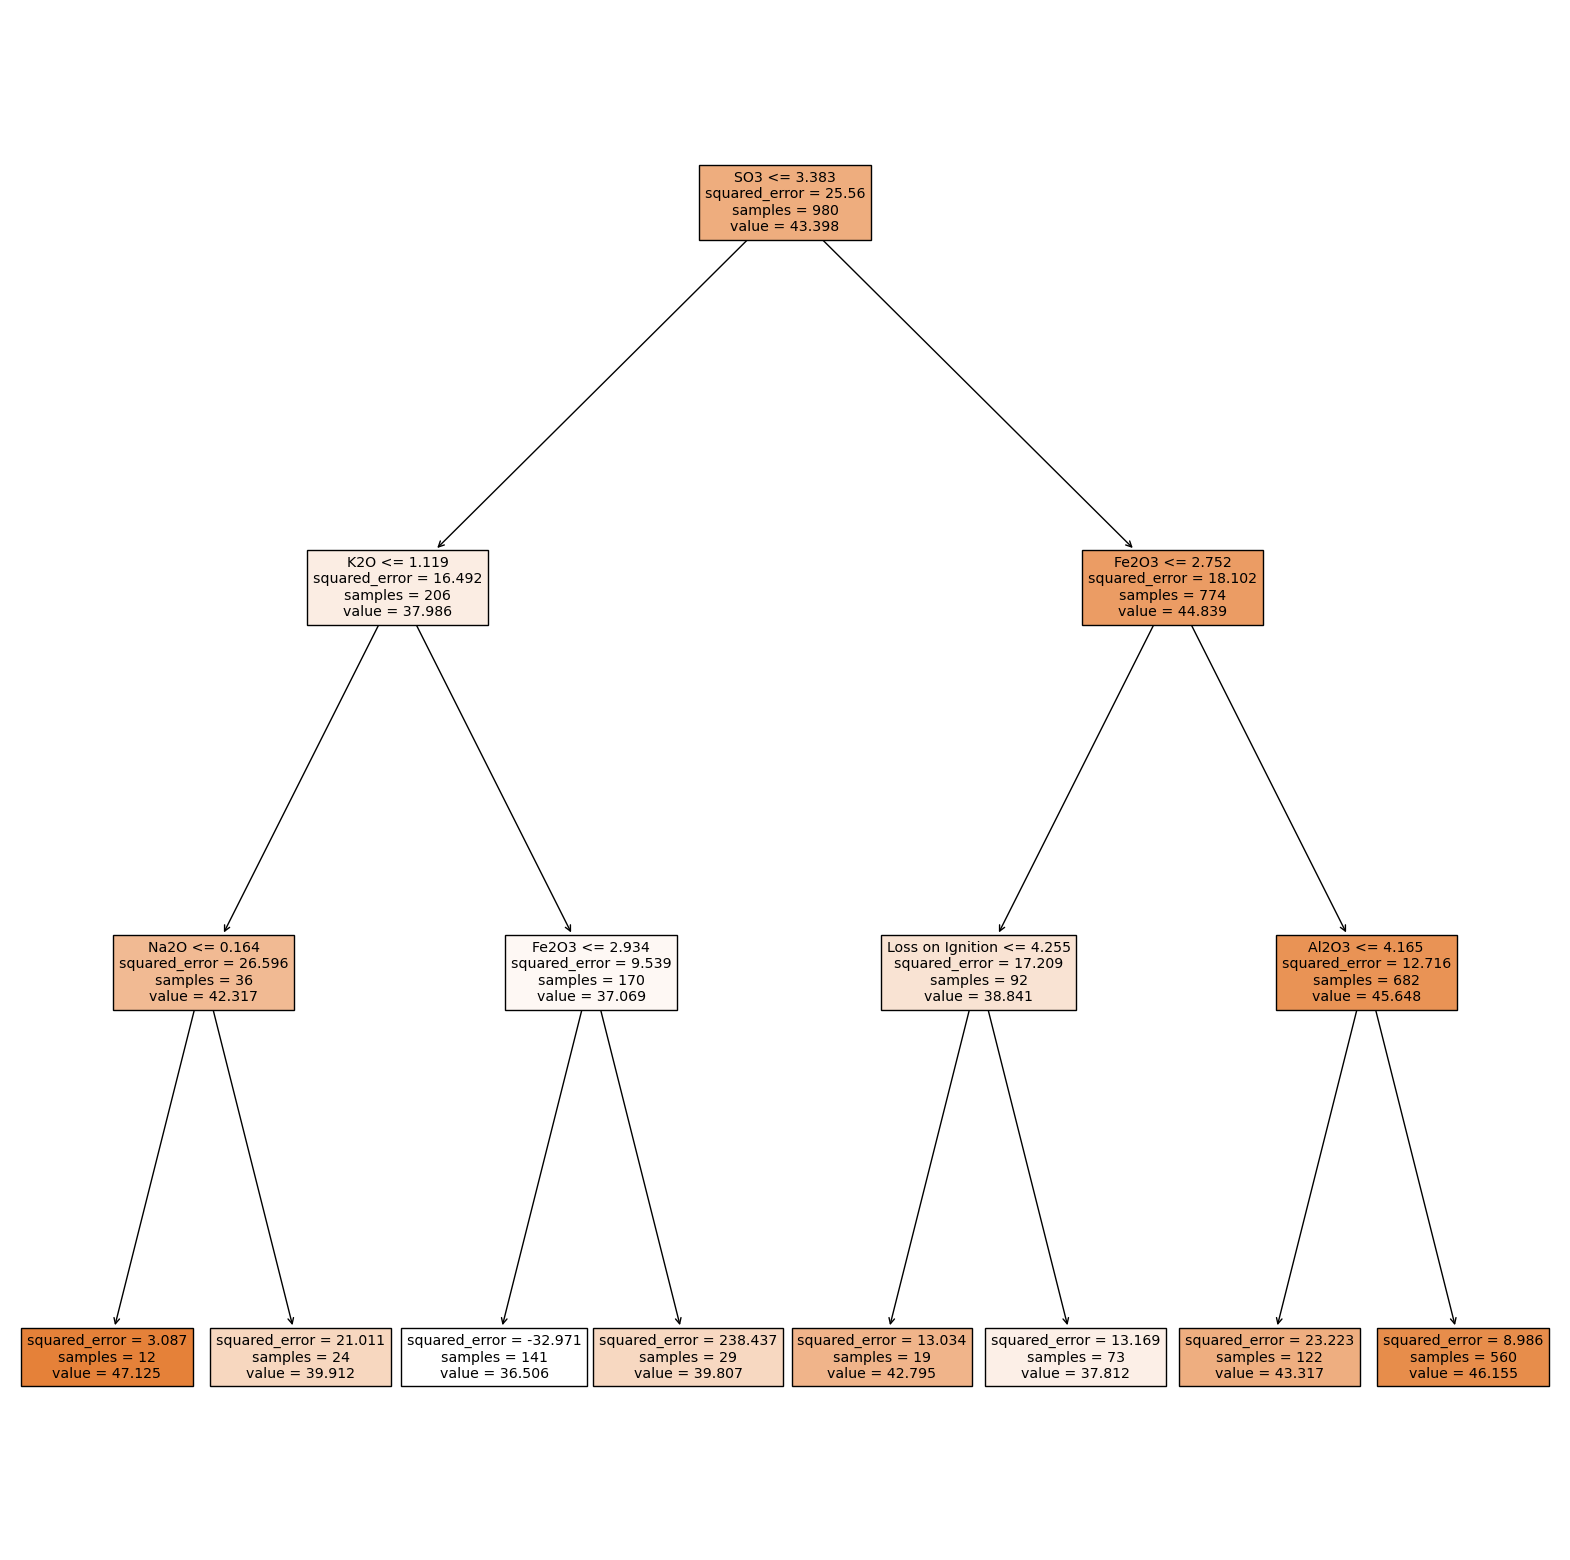

<IPython.core.display.Javascript object>

In [19]:
model = pipeline.get_params()["steps"][0][1]
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
_ = plot_tree(model, filled=True, feature_names=x.columns.to_list(), ax=ax)

<Axes: >

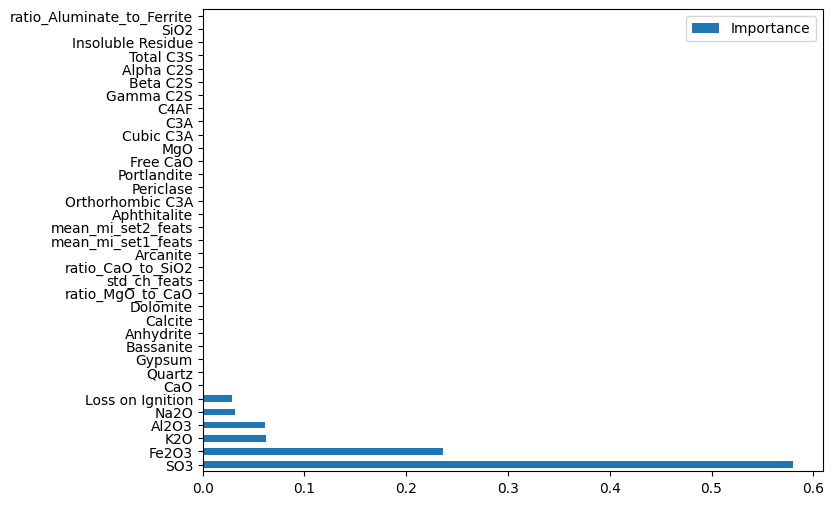

<IPython.core.display.Javascript object>

In [20]:
feat_importances = pd.DataFrame(
    model.feature_importances_, index=x.columns, columns=["Importance"]
)
feat_importances.sort_values(by="Importance", ascending=False, inplace=True)
feat_importances.plot(kind="barh", figsize=(8, 6))

In [21]:
df = pd.concat(
    [pd.DataFrame({"y": y_train_pred}), pd.DataFrame({"y": y_test_pred})]
).reset_index(drop=True)

<IPython.core.display.Javascript object>

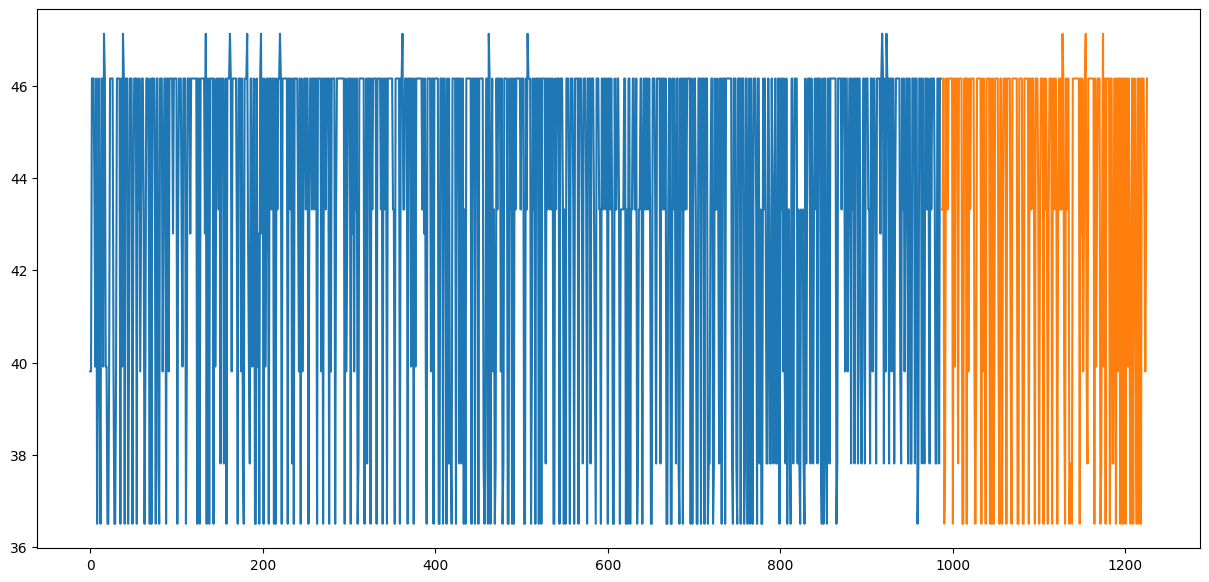

<IPython.core.display.Javascript object>

In [22]:
plt.figure(figsize=(15, 7))
plt.plot(df.iloc[:987])
plt.plot(df.iloc[987:])

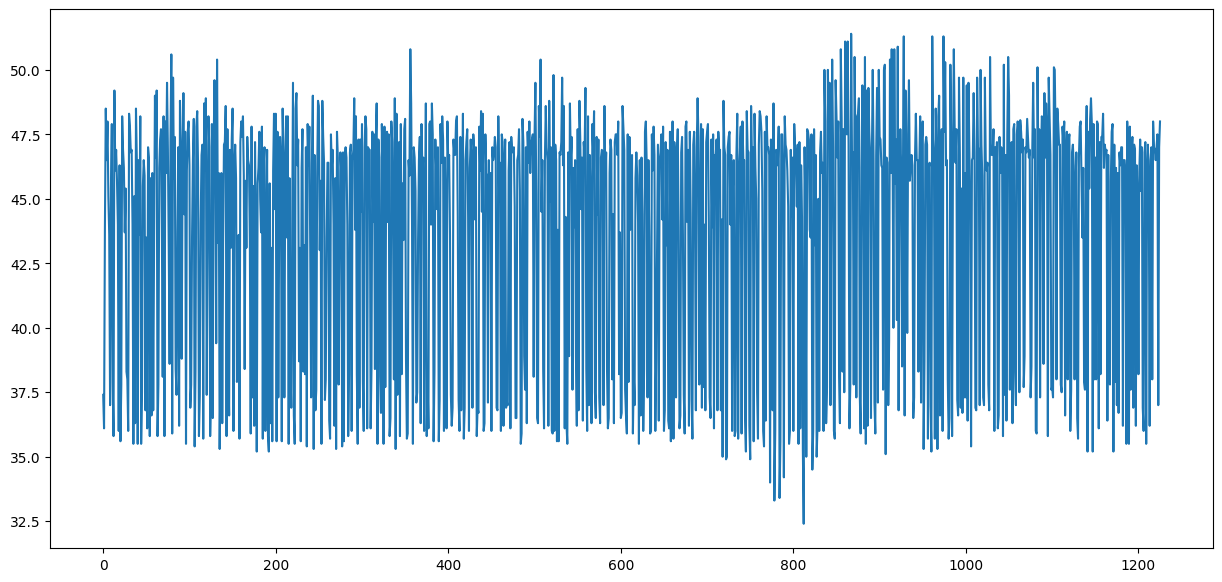

<IPython.core.display.Javascript object>

In [23]:
plt.figure(figsize=(15, 7))
plt.plot(y)

In [24]:
PARAMS

{'criterion': 'squared_error',
 'max_depth': 3,
 'random_state': 47,
 'splitter': 'best'}

<IPython.core.display.Javascript object>